# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.1


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\Daney\\.keras\\datasets\\auto-mpg.data'

Importelo usando pandas.

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpia los datos

Trata los missings y variables categóricas

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape)
print(test_dataset.shape)

(314, 8)
(78, 8)


### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

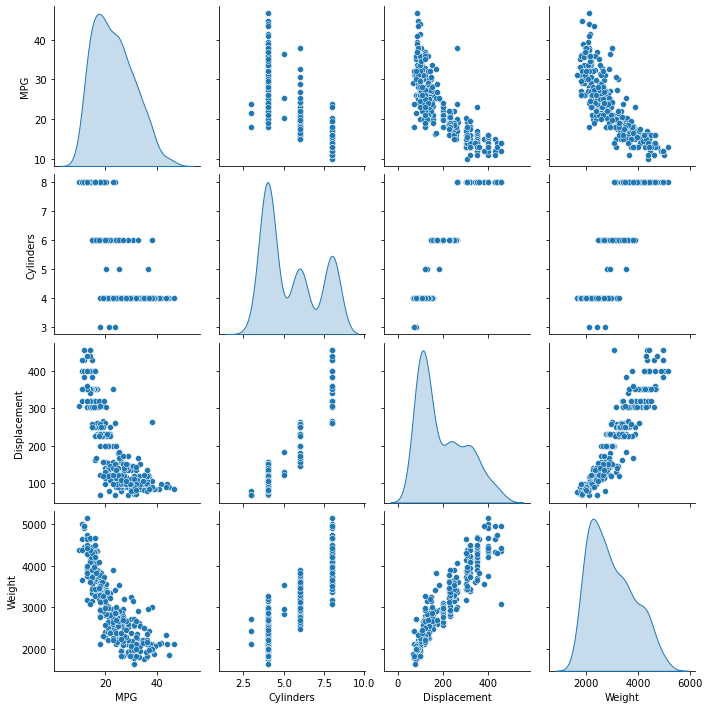

In [9]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Tambien revise las estadisticas generales:

In [10]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,1.573248
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.800988
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,1.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,2.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,3.000000


### Separa las features del target

Separe el target de las features.

In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train_dataset)
train_dataset = scaler.transform(train_dataset)
test_dataset = scaler.transform(test_dataset)

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [18]:
train_dataset.shape[1]

7

In [21]:
model = keras.Sequential([
    layers.Dense(64,
                 activation='relu',
                 input_shape=[train_dataset.shape[1]]),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
             optimizer=tf.keras.optimizers.RMSprop(0.001),
             metrics = ['mae', 'mse'])

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [23]:
history = model.fit(train_dataset,
                   train_labels,
                   epochs=1000,
                   validation_split=0.2)

Epoch 1/1000
8/8 [==============================] - 1s 74ms/step - loss: 575.3949 - mae: 22.7265 - mse: 575.3949 - val_loss: 575.1438 - val_mae: 22.6745 - val_mse: 575.1438
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 536.1874 - mae: 21.8450 - mse: 536.1874 - val_loss: 535.9018 - val_mae: 21.7842 - val_mse: 535.9018
Epoch 3/1000
8/8 [==============================] - 0s 10ms/step - loss: 498.2428 - mae: 20.9568 - mse: 498.2428 - val_loss: 491.2710 - val_mae: 20.7263 - val_mse: 491.2710
Epoch 4/1000
8/8 [==============================] - 0s 13ms/step - loss: 454.1013 - mae: 19.8920 - mse: 454.1013 - val_loss: 440.1041 - val_mae: 19.4456 - val_mse: 440.1041
Epoch 5/1000
8/8 [==============================] - 0s 15ms/step - loss: 405.4607 - mae: 18.6195 - mse: 405.4607 - val_loss: 385.8150 - val_mae: 18.0019 - val_mse: 385.8150
Epoch 6/1000
8/8 [==============================] - 0s 12ms/step - loss: 353.8838 - mae: 17.2022 - mse: 353.8838 - val_loss: 330.3402 - 

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.644256,1.025331,2.644256,9.704791,2.473133,9.704791,995
996,2.554650,1.022586,2.554650,9.865842,2.446059,9.865842,996
997,2.381479,0.969905,2.381479,9.809898,2.442262,9.809898,997
998,2.455505,0.969880,2.455505,11.107036,2.463581,11.107036,998
999,2.475912,0.986249,2.475912,10.119323,2.482510,10.119323,999


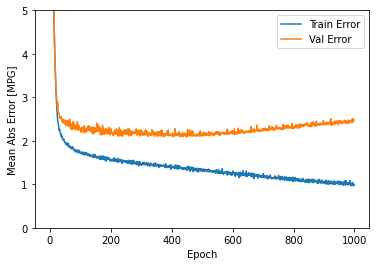

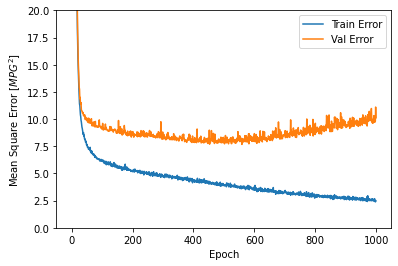

In [25]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

¿Alguna conclusión respecto a este gráfico?

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

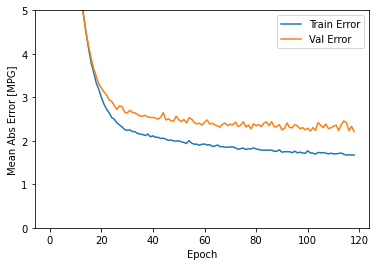

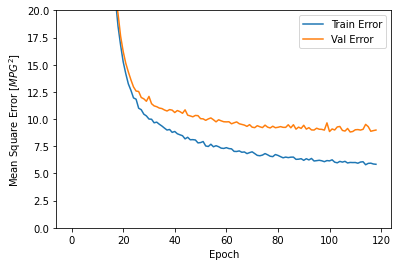

In [26]:
model = keras.Sequential([
    layers.Dense(64,
                 activation='relu',
                 input_shape=[train_dataset.shape[1]]),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
             optimizer=tf.keras.optimizers.RMSprop(0.001),
             metrics = ['mae', 'mse'])


history = model.fit(train_dataset,
                   train_labels,
                   epochs=1000,
                   validation_split=0.2,
                   verbose=0,
                   callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])
plot_history(history)

Interpreta el gráfico

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [28]:
loss, mae, mse = model.evaluate(test_dataset,
                                test_labels)
print("loss:", loss)
print("mae:", mae)
print("mse:", mse)

3/3 [==============================] - 0s 1ms/step - loss: 7.2388 - mae: 2.0790 - mse: 7.2388
loss: 7.238792419433594
mae: 2.078977584838867
mse: 7.238792419433594


Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

In [33]:
train_dataset.shape

(314, 7)

In [30]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[31.033997],
       [24.877361],
       [12.72515 ],
       [37.74849 ],
       [36.483387],
       [20.818932],
       [38.89886 ],
       [30.13638 ],
       [19.42443 ],
       [25.028519]], dtype=float32)

In [31]:
train_labels[:10]

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
257    19.4
310    38.1
328    30.0
125    20.0
108    20.0
Name: MPG, dtype: float64

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

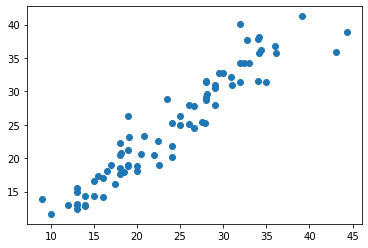

In [36]:
test_predictions = model.predict(test_dataset).flatten()
plt.scatter(test_labels, test_predictions);

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

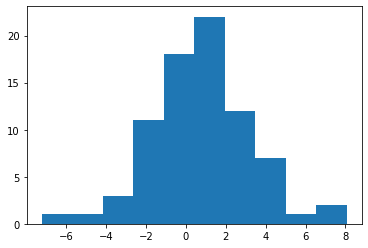

In [38]:
error = test_predictions - test_labels
plt.hist(error);

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.